In [46]:
model_name = "geosse"
trees_directory = "trees/"
num_states = 3

# part of the relative path for writing down the output files
chemin = './trained_models/' + model_name + '/'

# the suffix of output files
expname='6650_geosse'

In [3]:
import os
import numpy as np
from ete3 import Tree

class TreeEncoder:

    def encode_tree(self, tree_str):
        """
        Encode the tree structure into a format suitable for input into the neural network.
        """
        # Check if the tree is already encoded
        csv_file = tree_str[:-4] + '.csv'
        if os.path.exists(csv_file):
            return csv_file
        # Call the external script to get CDV encoding
        cmd = f"python -m CDV_full_tree -t {tree_str} -f {csv_file}" # > {tree_str[:-4]}.csv"
        os.system(cmd)
        

    def encode_all_trees(self, trees_directory):
        """
        Encode all the trees in the given directory.
        """
        tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]
        for tree_file in tree_files:
            print(tree_file)
            self.encode_tree(tree_file)


In [134]:
import sys

encoder = TreeEncoder()
encoded_trees = encoder.encode_all_trees(trees_directory)

trees/bd.nwk
trees/bisse.nwk
trees/bisseness.nwk
trees/classe.nwk
trees/classe_2.nwk
trees/geosse.nwk
trees/musse.nwk
trees/musse_90k.nwk
trees/quasse.nwk


Check if the musse.csv is empty, in that case run
* python -m CDV_full_tree -t trees/musse.nwk -f trees/musse.csv

from linux terminal!

In [48]:
import pandas as pd

# Load parameter values as a dataframe
tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]


if model_name == "bd":
    column_names = ['lambda', 'mu']
elif model_name == "bisse":
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21']
elif model_name == "musse":
    '''
    λ1, . . . , λK, µ1, . . . , µK, qij
    Generalizing BiSSE to K
    character states with constant
    rates.
    '''
    if num_states == 3:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif num_states == 4:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'lambda4', 'mu1', 'mu2', 'mu3', 'mu4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    else:
        print("Not implemented for more than 4 states")
elif model_name == "geosse":
    '''
    sA, sB, sAB, xA, xB, dA, dB    
    Accounts for geographical
    considerations with constant
    rates of speciation, extinction,
    and dispersal.'''
    column_names = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
elif model_name == "bisseness":
    '''
    λ0, λ1, µ0, µ1, q12, q21, p0c, p0a, p1c, p1a
    Estimates rates of change occurring along lineages and
    probabilities of change during
    speciation.
    '''
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
elif model_name == "classe":
    '''
    λklm (where 1 ≤ k, l, m ≤ n),
    µk (where 1 ≤ k ≤ n),
    qlm (where 1 ≤ l ̸= m ≤ n)
    Distinguishes between anagenetic and cladogenetic speciation with variable rates.
    There will be n^2 cladogenesis rates and n extinction rates
    plus n(n-1) transition rates, making a total of n^2+n+n(n-1) parameters.
    
    Two character states:
    • λ111: Rate of cladogenesis generating progeny inheriting the first character
    state if the parent already possessed said attribute.
    • λ112: Rate of cladogenesis leading to descendants adopting the second
    character state when parents initially bore the initial feature.
    • λ122: Analogous scenario but with reversed roles in character acquisition
    order.
    3
    Figure 2: Anagenesis and Cladogenesis.
    • λ211: Another case wherein children adopt the first characteristic after the
    parent had shifted to the second configuration.
    • λ212: Identical context as above except the final outcome reflects the emergence of the second character state in offspring.
    • λ222: Parallel situation to the preceding cases yet with both parents and
    descendants uniformly exhibiting the latter trait.
    • µ1: Extinction rate attributed to the primary character state.
    • µ2: Loss rate ascribed to the secondary character state.
    • q12: Shift rate towards obtaining the second character state starting from
    the first.
    • q21: Reverse transformation rate moving away from the first characteristic
    toward attaining the second.
    '''
    if num_states == 2:
        column_names = ['lambda111', 'lambda112', 'lambda122', 'lambda211', 'lambda212', 'lambda222', 'mu1', 'mu2', 'q12', 'q21']
    else:
        print("Not implemented yet for more than 2 states")
        
    


def process_params(param_file):
    # Reads the parameter file and saves the values in a csv file, one tree per row.
    # If the parameter file is already in the csv format, return
    if param_file.endswith('.csv'):
        return
    with open(param_file, 'r') as f:
        lines = f.readlines()
    param_values = []
    for line in lines:
        if model_name == 'musse' or model_name == 'classe':
            if line.startswith('num_states'):
                param_values.append([])
            else:
                param_values[-1].append(line.split()[1])
        elif model_name == 'bisse' or model_name == 'bd' or model_name == 'bisseness':
            if line.startswith('lambda1'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'geosse':
            if line.startswith('sp_a'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        else:
            print("Model not implemented")
    param_df = pd.DataFrame(param_values)
    param_df.to_csv(param_file + '.csv', sep='\t', header=False, index=False)
        
        
    
    
param_file = trees_directory + model_name + '.params'
process_params(param_file)


cutoff = 0.8  # Number of train trees
param = pd.read_csv(param_file + '.csv' , sep='\t', header=None)

cutoff = int(cutoff * param.shape[0])

param_train = param.iloc[:cutoff, :]
param_test = param.iloc[cutoff:, :]

print(param_train.columns)
print(column_names)

# Check that the number of columns is correct
assert param_train.shape[1] == len(column_names)

print(param_train.shape)
print(param_test.shape)



def rename_columns(df, names):
    df = df.rename(columns={i: names[i] for i in df.columns})
    return df

param_train = rename_columns(param_train, column_names)
param_test = rename_columns(param_test, column_names)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height, 500 values for tip states ('1' or '2')
# 1 value for tree height and 500 values for internal node heights
# + 2 values for nb of tips of each type (to be removed) and 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)

# split the encoding into train and test (cutoff is 0.8% of the data)
# read csv and know that there are empty rows for each row of the dataframe
encoding = pd.read_csv(trees_directory + model_name + '.csv', sep='\t', header=None, index_col=0)

encoding_train = encoding.iloc[:cutoff, :]
encoding_test = encoding.iloc[cutoff:, :]

print(encoding_train.shape)
print(encoding_test.shape)

print("Number of trees in parameters file: ", param.shape[0])
print("Number of trees in encoding file: ", encoding.shape[0])

if (param.shape[0] != encoding.shape[0]):
    print("Number of trees in parameters file and encoding file do not match, taking the last common number of trees")
    encoding = encoding.iloc[-param.shape[0]:, :]
    encoding_train = encoding.iloc[:cutoff, :]
    encoding_test = encoding.iloc[cutoff:, :]
    print("Number of trees in encoding file: ", encoding.shape[0])

# make sure there is correspondance between indexes of dataframe with parameter values and encodings
encoding_train.index = param_train.index
encoding_test.index = param_test.index

# check
param_test

# check
print(encoding_test.shape)
print(param_train)

# check
encoding_test

Index([0, 1, 2, 3, 4, 5, 6], dtype='int64')
['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
(5320, 7)
(1330, 7)
(5320, 1002)
(1330, 1002)
Number of trees in parameters file:  6650
Number of trees in encoding file:  6650
(1330, 1002)
            sA        sB       sAB        xA        xB        dA        dB
0     0.540483  0.807479  0.673899  0.387643  0.958779  0.915918  0.975399
1     0.219381  0.406167  0.736299  0.018943  0.893449  0.905867  0.513750
2     0.645535  0.484634  0.936610  0.676672  0.962465  0.313658  0.562590
3     0.869718  0.362252  0.279539  0.120835  0.868078  0.201208  0.591039
4     0.703904  0.844828  0.336594  0.221830  0.063213  0.957326  0.799902
...        ...       ...       ...       ...       ...       ...       ...
5315  0.594783  0.760756  0.186886  0.961872  0.030581  0.155596  0.440240
5316  0.399509  0.346222  0.575534  0.128749  0.617054  0.132350  0.694154
5317  0.773484  0.232942  0.518937  0.070086  0.094314  0.393326  0.256467
5318  0.989193  0.700

,1,2,3,4,5,6,7,8,9,10,...,993,994,995,996,997,998,999,1000,1001,1002
5320,16.934926,15.224809,15.083956,16.426525,16.932417,14.511336,16.218879,14.277568,14.068588,15.492047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.841774
5321,11.048519,9.181923,10.849701,11.014922,8.539327,9.996269,10.979882,10.918310,10.856751,7.399561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.872800
5322,14.483102,12.274260,13.119618,14.209589,13.415328,14.374859,14.474499,12.028227,12.288877,14.361362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.828918
5323,12.130638,10.810780,10.168690,10.543204,11.998331,9.686479,11.008417,10.366861,9.560798,7.764314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.732715
5324,10.984033,10.463083,9.954686,9.358396,9.180197,9.766083,9.356343,10.728067,10.027501,10.835432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6645,11.717041,10.839920,10.732443,10.007157,10.662059,11.688865,10.518191,11.435055,9.996981,9.371546,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441024
6646,12.295280,10.143172,11.962931,10.079968,11.079703,12.194992,11.008393,11.971026,9.645957,10.861073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.531908
6647,4.903388,2.298750,3.929849,4.903388,1.879435,3.124330,0.024436,4.414232,0.000000,3.248903,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461670
6648,11.109706,10.518747,10.020685,10.893678,10.834897,9.877387,10.694896,9.339353,8.711831,7.633311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.503454


In [51]:
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
print(len(encoding_train.columns))
# get the normalization factor that is stored in the last column of the encoding
param_train['norm_factor'] = encoding_train.iloc[:, -1]

print(param_train['norm_factor'])

# add to the parameter dataframe the net rate values, that are the difference between lambda and mu for each state
# and rescale target values according to scaling factor
if model_name == 'bd':
    param_train['mu_rescaled'] = param_train['mu']*param_train['norm_factor']
    param_train['lambda_rescaled'] = param_train['lambda']*param_train['norm_factor']

elif model_name == 'bisse':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        
    elif num_states == 4:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['mu4_rescaled'] = param_train['mu4']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['lambda4_rescaled'] = param_train['lambda4']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q14_rescaled'] = param_train['q14']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q24_rescaled'] = param_train['q24']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        param_train['q34_rescaled'] = param_train['q34']*param_train['norm_factor']
        param_train['q41_rescaled'] = param_train['q41']*param_train['norm_factor']
        param_train['q42_rescaled'] = param_train['q42']*param_train['norm_factor']
        param_train['q43_rescaled'] = param_train['q43']*param_train['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_train['xA_rescaled'] = param_train['xA']*param_train['norm_factor']
    param_train['xB_rescaled'] = param_train['xB']*param_train['norm_factor']
    param_train['sA_rescaled'] = param_train['sA']*param_train['norm_factor']
    param_train['sB_rescaled'] = param_train['sB']*param_train['norm_factor']
    param_train['sAB_rescaled'] = param_train['sAB']*param_train['norm_factor']
    param_train['dA_rescaled'] = param_train['dA']*param_train['norm_factor']
    param_train['dB_rescaled'] = param_train['dB']*param_train['norm_factor']

elif model_name == 'bisseness':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
    param_train['p1c_rescaled'] = param_train['p1c']*param_train['norm_factor']
    param_train['p1a_rescaled'] = param_train['p1a']*param_train['norm_factor']
    param_train['p2c_rescaled'] = param_train['p2c']*param_train['norm_factor']
    param_train['p2a_rescaled'] = param_train['p2a']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    

elif model_name == 'classe':
    param_train['mu11_rescaled'] = param_train['mu11']*param_train['norm_factor']
    param_train['mu12_rescaled'] = param_train['mu12']*param_train['norm_factor']
    param_train['mu22_rescaled'] = param_train['mu22']*param_train['norm_factor']
    param_train['mu21_rescaled'] = param_train['mu21']*param_train['norm_factor']
    



### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test.iloc[:, -1]

if model_name == 'bd':
    param_test['mu_rescaled'] = param_test['mu']*param_test['norm_factor']
    param_test['lambda_rescaled'] = param_test['lambda']*param_test['norm_factor']

elif model_name == 'bisse':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        
    elif num_states == 4:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['mu4_rescaled'] = param_test['mu4']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['lambda4_rescaled'] = param_test['lambda4']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q14_rescaled'] = param_test['q14']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q24_rescaled'] = param_test['q24']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        param_test['q34_rescaled'] = param_test['q34']*param_test['norm_factor']
        param_test['q41_rescaled'] = param_test['q41']*param_test['norm_factor']
        param_test['q42_rescaled'] = param_test['q42']*param_test['norm_factor']
        param_test['q43_rescaled'] = param_test['q43']*param_test['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_test['xA_rescaled'] = param_test['xA']*param_test['norm_factor']
    param_test['xB_rescaled'] = param_test['xB']*param_test['norm_factor']
    param_test['sA_rescaled'] = param_test['sA']*param_test['norm_factor']
    param_test['sB_rescaled'] = param_test['sB']*param_test['norm_factor']
    param_test['sAB_rescaled'] = param_test['sAB']*param_test['norm_factor']
    param_test['dA_rescaled'] = param_test['dA']*param_test['norm_factor']
    param_test['dB_rescaled'] = param_test['dB']*param_test['norm_factor']
    
elif model_name == 'bisseness':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
    param_test['p1c_rescaled'] = param_test['p1c']*param_test['norm_factor']
    param_test['p1a_rescaled'] = param_test['p1a']*param_test['norm_factor']
    param_test['p2c_rescaled'] = param_test['p2c']*param_test['norm_factor']
    param_test['p2a_rescaled'] = param_test['p2a']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    

elif model_name == 'classe':
    param_test['mu11_rescaled'] = param_test['mu11']*param_test['norm_factor']
    param_test['mu12_rescaled'] = param_test['mu12']*param_test['norm_factor']
    param_test['mu22_rescaled'] = param_test['mu22']*param_test['norm_factor']
    param_test['mu21_rescaled'] = param_test['mu21']*param_test['norm_factor']

1002
0       0.655152
1       1.179875
2       1.401543
3       0.593356
4       0.444662
          ...   
5315    0.617350
5316    1.287072
5317    0.639716
5318    0.672644
5319    1.063866
Name: norm_factor, Length: 5320, dtype: float64


In [52]:
print(encoding_train.shape)
print(encoding_test.shape)

(5320, 1002)
(1330, 1002)


In [53]:
"""# Drop all information on tip states, excluding the tip state count
columns_to_drop = [i for i in range(2,1003)]
#Reshape features
encoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)
encoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)
#first_line = pd.DataFrame(table_eigenValues.columns).T"""

'# Drop all information on tip states, excluding the tip state count\ncolumns_to_drop = [i for i in range(2,1003)]\n#Reshape features\nencoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)\nencoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)\n#first_line = pd.DataFrame(table_eigenValues.columns).T'

In [54]:
# plot lambda and lambda_rescaled in a way to see where it is rescaling
import matplotlib.pyplot as plt
plt.scatter(param_train['lambda1'], param_train['lambda1_rescaled'], s=1)
# add a diagonal line from min to max
plt.plot([min(param_train['lambda1']), max(param_train['lambda1'])], [min(param_train['lambda1']), max(param_train['lambda1'])], color='red')
plt.xlabel('lambda')
plt.ylabel('lambda_rescaled')
plt.title('Rescaling of lambda')
plt.show()

KeyError: 'lambda1'

In [55]:
encoding_train.shape

(5320, 1002)

In [57]:
# Write to csv
param_train.to_csv(chemin + '/param_train' + expname + '.csv')
param_test.to_csv(chemin + '/param_test' + expname + '.csv')
encoding_train.to_csv(chemin + '/encoding_train' + expname + '.csv')
encoding_test.to_csv(chemin + '/encoding_test' + expname + '.csv')

In [58]:
# Read the data
param_train = pd.read_csv(chemin + '/param_train' + expname + '.csv', index_col=0)
param_test = pd.read_csv(chemin + '/param_test' + expname + '.csv', index_col=0)
encoding_train = pd.read_csv(chemin + '/encoding_train' + expname + '.csv', index_col=0)
encoding_test = pd.read_csv(chemin + '/encoding_test' + expname + '.csv', index_col=0)

In [59]:
#Choice of the parameters to predict

if model_name == "musse":
    if num_states == 3:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'mu1_rescaled'
        target5 = 'mu2_rescaled'
        target6 = 'mu3_rescaled'
        target7 = 'q12_rescaled'
        target8 = 'q13_rescaled'
        target9 = 'q21_rescaled'
        target10 = 'q23_rescaled'
        target11 = 'q31_rescaled'
        target12 = 'q32_rescaled'
        
        targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6]])#, target7, target8, target9, target10, target11, target12]])
        targets2 = pd.DataFrame(param_train[[target7, target8, target9, target10, target11, target12]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6]])#, target7, target8, target9, target10, target11, target12]])
        targets_test2 = pd.DataFrame(param_test[[target7, target8, target9, target10, target11, target12]])


        
    elif num_states == 4:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'lambda4_rescaled'
        target5 = 'mu1_rescaled'
        target6 = 'mu2_rescaled'
        target7 = 'mu3_rescaled'
        target8 = 'mu4_rescaled'
        target9 = 'q12_rescaled'
        target10 = 'q13_rescaled'
        target11 = 'q14_rescaled'
        target12 = 'q21_rescaled'
        target13 = 'q23_rescaled'
        target14 = 'q24_rescaled'
        target15 = 'q31_rescaled'
        target16 = 'q32_rescaled'
        target17 = 'q34_rescaled'
        target18 = 'q41_rescaled'
        target19 = 'q42_rescaled'
        target20 = 'q43_rescaled'

        # select the columns of the dataframe that correspond to the target values
        target = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        
elif model_name == "bd":
    target1 = 'lambda_rescaled'
    target2 = 'mu_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2]])
    targets_test = pd.DataFrame(param_test[[target1, target2]])
    
elif model_name == "bisse":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6]])
    
elif model_name == "geosse":
    target1 = 'sA_rescaled'
    target2 = 'sB_rescaled'
    target3 = 'sAB_rescaled'
    target4 = 'xA_rescaled'
    target5 = 'xB_rescaled'
    target6 = 'dA_rescaled'
    target7 = 'dB_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7]])
    
elif model_name == "bisseness":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    target7 = 'p1c_rescaled'
    target8 = 'p1a_rescaled'
    target9 = 'p2c_rescaled'
    target10 = 'p2a_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    
elif model_name == "classe":
    target1 = 'lambda111_rescaled'
    target2 = 'lambda112_rescaled'
    target3 = 'lambda122_rescaled'
    target4 = 'lambda211_rescaled'
    target5 = 'lambda212_rescaled'
    target6 = 'lambda222_rescaled'
    target7 = 'mu1_rescaled'
    target8 = 'mu2_rescaled'
    target9 = 'q12_rescaled'
    target10 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    
features = encoding_train
features_test = encoding_test

# how large is the validation set in percentage of the total number of trees
valid_frac = 0.2
train_size_frac = 1 - valid_frac

print(targets.shape)

(5320, 7)


In [60]:
print("Validation set fraction: ", valid_frac)
print("Training set fraction: ", train_size_frac)

Validation set fraction:  0.2
Training set fraction:  0.8


In [18]:
'''
#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = pd.DataFrame(param_train[add_target])
features['1003'] = added_targets
features['1004'] = added_targets
features['1005'] = added_targets
features['1006'] = added_targets
features['1007'] = added_targets
features['1008'] = added_targets

added_targets2 = pd.DataFrame(param_test[add_target])
features_test['1003'] = added_targets2
features_test['1004'] = added_targets2
features_test['1005'] = added_targets2
features_test['1006'] = added_targets2
features_test['1007'] = added_targets2
features_test['1008'] = added_targets2
'''

'\n#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)\nadd_target = "sampling_frac"\nadded_targets = pd.DataFrame(param_train[add_target])\nfeatures[\'1003\'] = added_targets\nfeatures[\'1004\'] = added_targets\nfeatures[\'1005\'] = added_targets\nfeatures[\'1006\'] = added_targets\nfeatures[\'1007\'] = added_targets\nfeatures[\'1008\'] = added_targets\n\nadded_targets2 = pd.DataFrame(param_test[add_target])\nfeatures_test[\'1003\'] = added_targets2\nfeatures_test[\'1004\'] = added_targets2\nfeatures_test[\'1005\'] = added_targets2\nfeatures_test[\'1006\'] = added_targets2\nfeatures_test[\'1007\'] = added_targets2\nfeatures_test[\'1008\'] = added_targets2\n'

In [61]:
# explore the data
print(features.shape)
print(targets.shape)
print(features_test.shape)

# print keys of target
print(targets.keys())
print(targets_test.keys())

(5320, 1002)
(5320, 7)
(1330, 1002)
Index(['sA_rescaled', 'sB_rescaled', 'sAB_rescaled', 'xA_rescaled',
       'xB_rescaled', 'dA_rescaled', 'dB_rescaled'],
      dtype='object')
Index(['sA_rescaled', 'sB_rescaled', 'sAB_rescaled', 'xA_rescaled',
       'xB_rescaled', 'dA_rescaled', 'dB_rescaled'],
      dtype='object')


In [62]:
features.describe()

,1,2,3,4,5,6,7,8,9,10,...,993,994,995,996,997,998,999,1000,1001,1002
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,...,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.0,5320.000000
mean,13.179551,11.649229,11.887317,11.871872,11.768146,11.700033,11.641104,11.618476,11.525770,11.530916,...,0.147442,0.131148,0.097933,0.090624,0.076882,0.060715,0.045742,0.037628,0.0,0.822573
std,3.688699,3.809583,3.846517,3.881694,3.887594,3.901468,3.923013,3.992255,3.963225,4.017477,...,1.481849,1.412461,1.204919,1.176958,1.066567,0.980705,0.885994,0.822722,0.0,0.387124
min,3.958880,0.375880,0.315887,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.240577
25%,10.967937,9.400651,9.609789,9.544435,9.412962,9.341860,9.248072,9.148867,9.114701,9.110322,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.578904
50%,12.810253,11.328664,11.546982,11.598874,11.481438,11.411301,11.344498,11.360367,11.266445,11.244869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.711644
75%,14.843956,13.516820,13.724850,13.659887,13.640842,13.626186,13.617233,13.536808,13.443430,13.561664,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.936182
max,47.608111,46.179151,46.862970,47.508116,47.572052,44.780017,46.676747,44.562585,47.368773,47.217521,...,33.913176,32.898355,34.126357,33.986733,24.245420,33.286339,34.082876,34.030705,0.0,5.262376


In [63]:
targets.describe()

,sA_rescaled,sB_rescaled,sAB_rescaled,xA_rescaled,xB_rescaled,dA_rescaled,dB_rescaled
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,0.437243,0.430618,0.453060,0.367560,0.366539,0.457100,0.449469
std,0.192715,0.192073,0.299498,0.329076,0.328551,0.295739,0.289306
min,0.051759,0.050913,0.043783,0.000005,0.000166,0.047478,0.048340
25%,0.310010,0.301125,0.244332,0.123821,0.125551,0.257718,0.251242
50%,0.434510,0.426181,0.401978,0.297535,0.290490,0.403593,0.397487
75%,0.535087,0.527811,0.582254,0.517226,0.511361,0.576798,0.569711
max,1.736835,1.592992,3.257103,4.390570,3.412232,2.969749,2.702644


In [64]:
if model_name == "musse" and targets2 is not None:
    targets2.describe()

In [65]:
#Standardization of the input features: done for summary statistics
import sklearn
from sklearn.preprocessing import StandardScaler

#Standardization of the input features

old_features = features
old_features_test = features_test

scale = StandardScaler()
features = scale.fit_transform(features)
features_test = scale.transform(features_test)


X = features
Y = targets

Y_test = targets_test
X_test = features_test

if model_name == "musse" and targets2 is not None:
    Y2 = targets2
    Y2_test = targets_test2


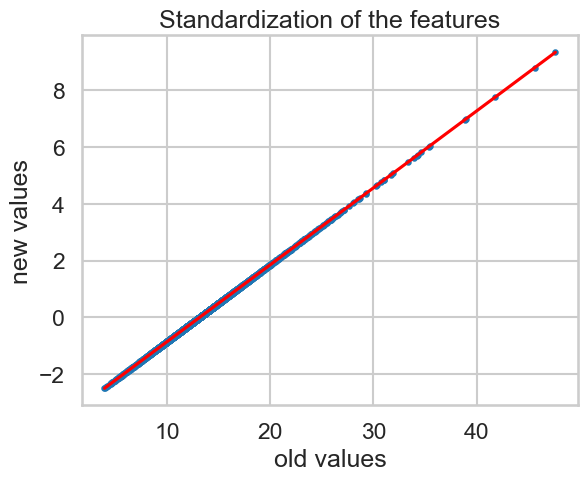

In [66]:
# Plot the old and new values of the features to see the effect of standardization
import matplotlib.pyplot as plt
plt.scatter(old_features.iloc[:, 0], features[:, 0], s=10)
plt.plot([min(old_features.iloc[:, 0]), max(old_features.iloc[:, 0])], [min(features[:, 0]), max(features[:, 0])], color='red')
plt.xlabel('old values')
plt.ylabel('new values')
plt.title('Standardization of the features')
plt.show()

In [67]:
X_test

array([[ 1.01817151,  0.93866348,  0.83112564, ..., -0.04574   ,
         0.        ,  0.04960355],
       [-0.57777338, -0.64771893, -0.26978012, ..., -0.04574   ,
         0.        ,  0.12975559],
       [ 0.35342374,  0.16408348,  0.32039804, ..., -0.04574   ,
         0.        ,  0.01639027],
       ...,
       [-2.24386485, -2.45469376, -2.06894079, ..., -0.04574   ,
         0.        , -0.93235567],
       [-0.56118413, -0.29677486, -0.48532421, ..., -0.04574   ,
         0.        , -0.82441144],
       [ 0.03897481, -0.05919933,  0.01660873, ..., -0.04574   ,
         0.        , -0.17653152]])

In [68]:
print(features.shape)

(5320, 1002)


In [26]:
"""
%pip install keras --upgrade -q
#%pip install --upgrade protobuf
%pip install --upgrade pandas -q
%pip install protobuf==3.20 -q
%pip install tensorflow -q
"""

'\n%pip install keras --upgrade -q\n#%pip install --upgrade protobuf\n%pip install --upgrade pandas -q\n%pip install protobuf==3.20 -q\n%pip install tensorflow -q\n'

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split

# Function to build the model
def build_model():
    model = Sequential()
    model.add(tf.keras.layers.Reshape((X.shape[1], 1), input_shape=(X.shape[1],)))
    
    # Convolutional layers
    model.add(Conv1D(filters=X.shape[1]/16, kernel_size=5, activation='relu'))
    model.add(Conv1D(filters=X.shape[1]/32, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(10))
    model.add(Conv1D(filters=80, kernel_size=10, activation='relu'))
    
    model.add(Flatten())
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    if model_name == "bisse" or True:
        model.add(Dense(8, activation='relu'))
        model.add(Dropout(0.3))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.summary()
    return model

# FFNN

def build_modelf():
    model = Sequential()
    
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(targets.shape[1], activation='relu'))
    model.summary()
    return model



In [71]:
#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

# Building the model
model = build_model()

# Compiling the model with a custom initial learning rate for Adam optimizer
initial_learning_rate = 0.005  # Custom initial learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)
model.compile(loss='mae', optimizer = adam_optimizer, metrics=[losses.mean_absolute_percentage_error])

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch % 100 == 0 and epoch:
        return lr * 0.8
    return lr

from tensorflow.keras.callbacks import LearningRateScheduler
# Learning rate scheduler callback
lr_schedule = LearningRateScheduler(lr_scheduler)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=100)

#display training progress for each completed epoch.
class PrintDot(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 10 == 0: print('')
    print('.', end='')


# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is NOT available")

# Force TensorFlow to use GPU if available
if tf.test.is_gpu_available():
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(session)

# Training the model on GPU
with tf.device('/GPU:0'):  # Specify GPU device
    history = model.fit(X, Y, epochs=10000, validation_split=valid_frac, batch_size=2048, callbacks=[early_stop, PrintDot(), lr_schedule])



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 1002, 1)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 998, 62)           372       
                                                                 
 conv1d_7 (Conv1D)           (None, 989, 31)           19251     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 98, 31)           0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 89, 80)            24880     
                                                                 
 flatten_2 (Flatten)         (None, 7120)              0         
                                                      

In [73]:
#expname = '51k_lambda_mu'

# Save the model
model.save(chemin + '/model_' + expname + '.h5')

In [ ]:
# Now do the same with targets2

if model_name == "musse" and targets2 is not None:
    # Building the model
    model2 = build_model()

    with tf.device('/GPU:0'):  # Specify GPU device
        history2 = model2.fit(X, Y2, epochs=250, validation_split=valid_frac, batch_size=2048, callbacks=[early_stop, PrintDot(), lr_schedule])

In [ ]:
if model_name == "musse" and targets2 is not None:
    # Save the model
    expname = '51k_q'
    model2.save(chemin + '/model2_' + expname + '.h5')

In [281]:
"""import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(12, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mse"],
    )
    return model


import keras_tuner

model = build_model(keras_tuner.HyperParameters())


#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

# Building the model
model = build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

tuner.search(X, Y, epochs=5, validation_split=0.2)

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

tuner.results_summary()"""

'import keras\nfrom keras import layers\n\n\ndef build_model(hp):\n    model = keras.Sequential()\n    model.add(layers.Flatten())\n    model.add(\n        layers.Dense(\n            # Tune number of units.\n            units=hp.Int("units", min_value=32, max_value=512, step=32),\n            # Tune the activation function to use.\n            activation=hp.Choice("activation", ["relu", "tanh"]),\n        )\n    )\n    # Tune whether to use dropout.\n    if hp.Boolean("dropout"):\n        model.add(layers.Dropout(rate=0.25))\n    model.add(layers.Dense(12, activation="softmax"))\n    # Define the optimizer learning rate as a hyperparameter.\n    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")\n    model.compile(\n        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),\n        loss="mse",\n        metrics=["mse"],\n    )\n    return model\n\n\nimport keras_tuner\n\nmodel = build_model(keras_tuner.HyperParameters())\n\n\n#Possibility of using

In [282]:
"""tuner.results_summary()

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
model.fit(X, Y, epochs=100, validation_split=0.2)"""

'tuner.results_summary()\n\n# Get the top 2 hyperparameters.\nbest_hps = tuner.get_best_hyperparameters(5)\n# Build the model with the best hp.\nmodel = build_model(best_hps[0])\n# Fit with the entire dataset.\nmodel.fit(X, Y, epochs=100, validation_split=0.2)'

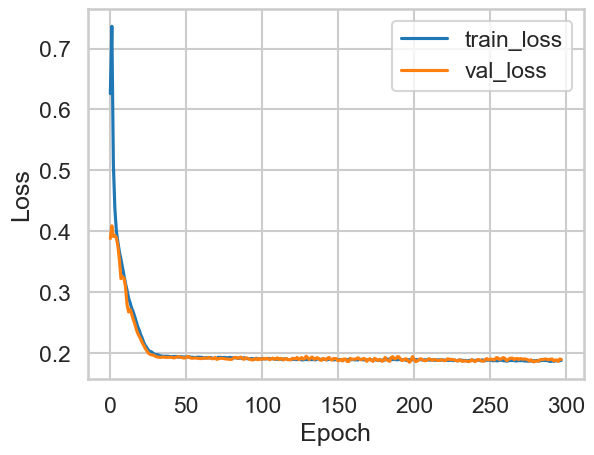

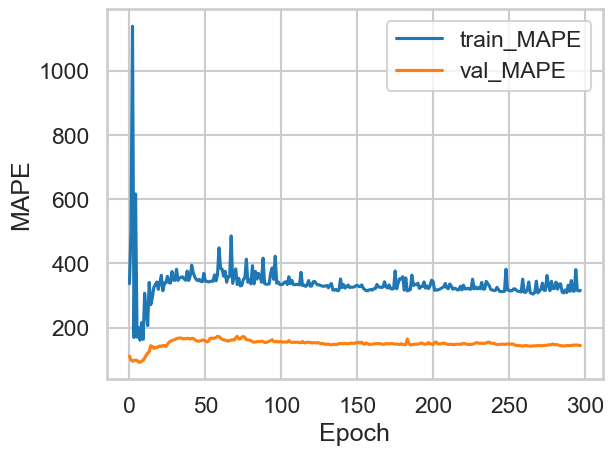

In [74]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'], label='train_MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.show()

In [75]:
# Make predictions on the test dataset
predictions = model.predict(X_test)
#predictions2 = model2.predict(X_test)

42/42 [==============================] - 0s 9ms/step


[[0.45842996 0.45857644 0.44471222 ... 0.34484535 0.4382196  0.419436  ]
 [0.42187896 0.41166568 0.3749662  ... 0.2336603  0.37970883 0.37561372]
 [0.45065838 0.44860214 0.42988265 ... 0.3212049  0.4257789  0.4101184 ]
 ...
 [0.42187896 0.41166568 0.3749662  ... 0.2336603  0.37970883 0.37561372]
 [0.42187896 0.41166568 0.3749662  ... 0.2336603  0.37970883 0.37561372]
 [0.42187896 0.41166568 0.3749662  ... 0.2336603  0.37970883 0.37561372]]
5320    0.570219
5321    0.321495
5322    0.606305
5323    0.652035
5324    0.134638
          ...   
6645    0.351638
6646    0.305925
6647    0.441838
6648    0.467366
6649    0.126199
Name: sA_rescaled, Length: 1330, dtype: float64
0.6420808
2.1484964480344426


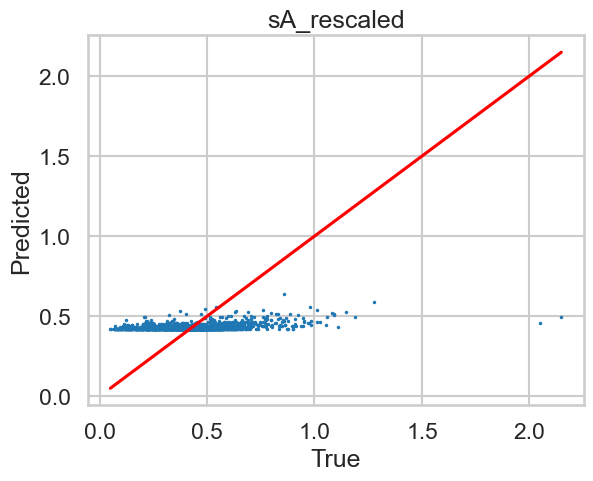

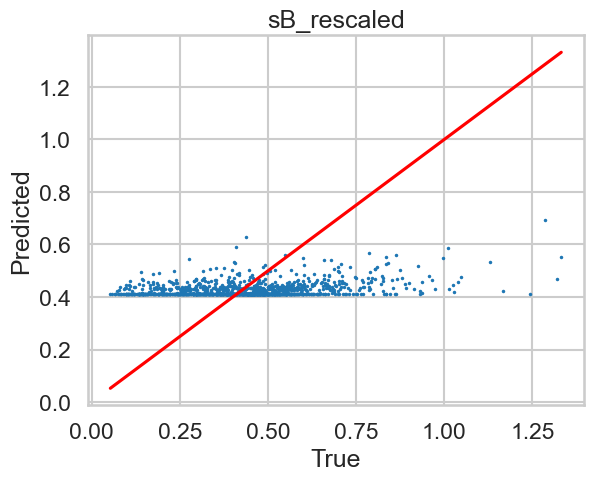

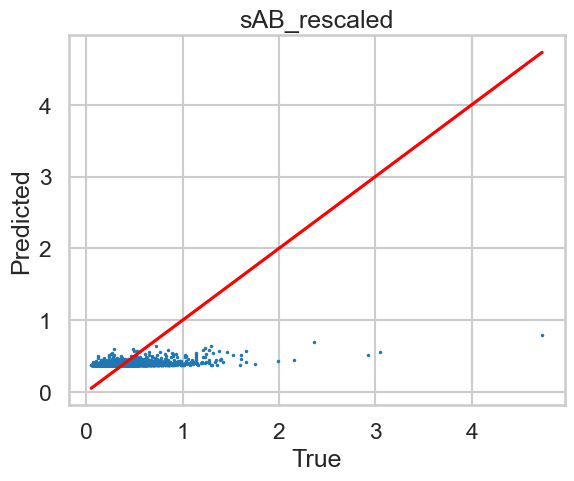

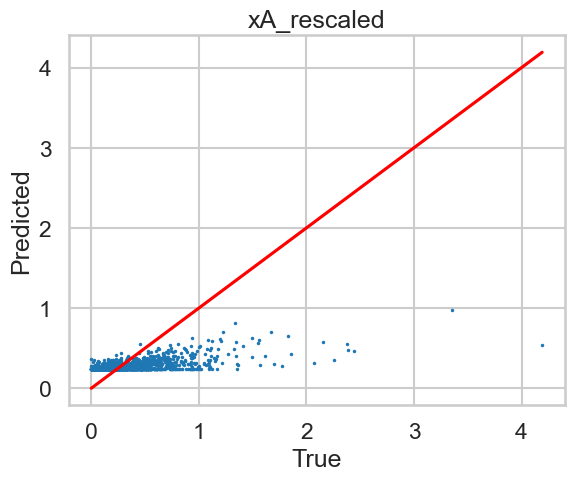

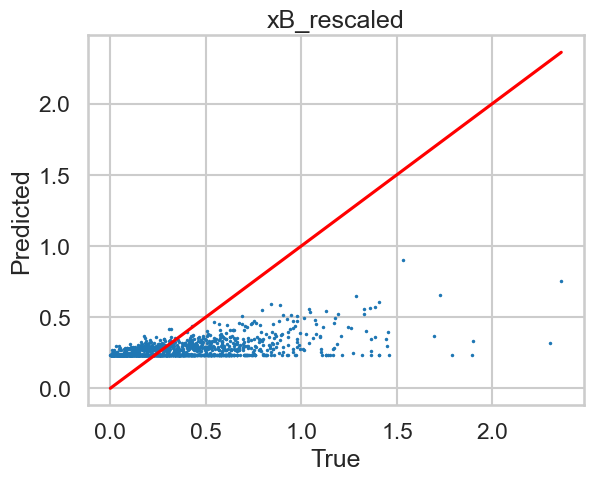

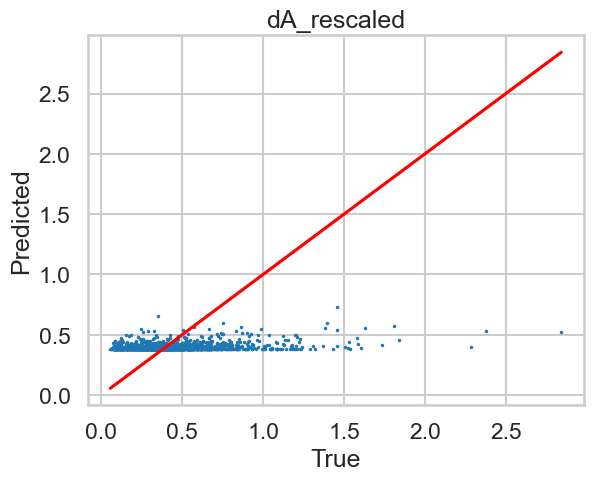

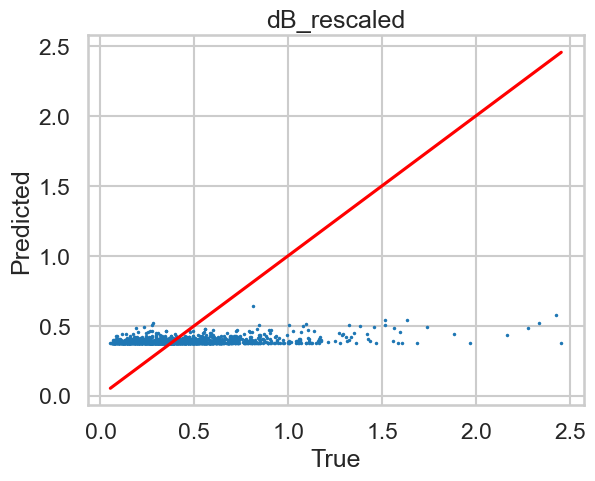

In [76]:
import matplotlib.pyplot as plt

print(predictions)
print(Y_test.iloc[:, 0])

print(max(predictions[:, 0]))
print(max(Y_test.iloc[:, 0]))

# plot predictions vs true values for each parameter in the training set
for i in range(predictions.shape[1]):
    plt.scatter(Y_test.iloc[:, i], predictions[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y_test.columns[i])
    # add a diagonal line
    plt.plot([Y_test.iloc[:, i].min(), Y_test.iloc[:, i].max()], [Y_test.iloc[:, i].min(), Y_test.iloc[:, i].max()], color='red')
    plt.show()



In [ ]:
for i in range(predictions2.shape[1]):
    plt.scatter(Y_test2.iloc[:, i], predictions2[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y_test2.columns[i])
    # add a diagonal line
    plt.plot([Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], [Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], color='red')
    plt.show()

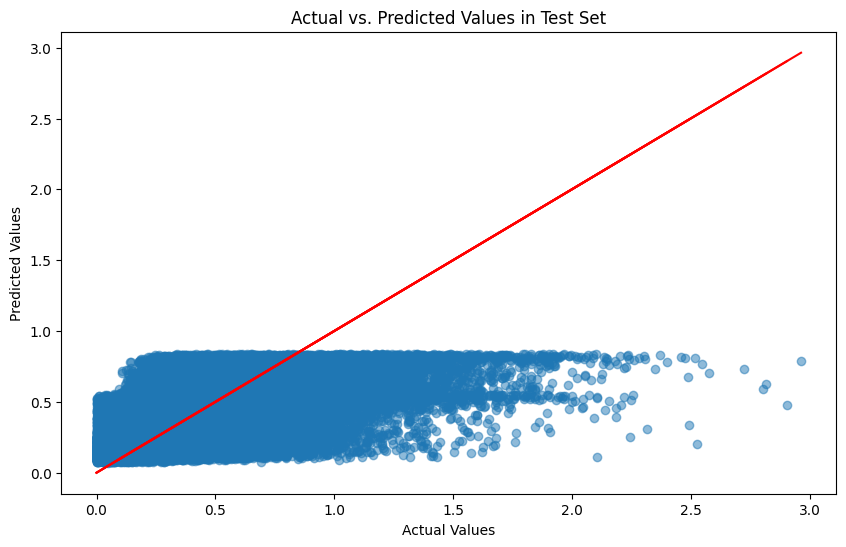

Mean Absolute Error (MAE):
 0.19651776290560483
Mean Absolute Percentage Error (MAPE):
 277.72229501577266


In [34]:
# Plot predictions vs. actuals
plt.figure(figsize=(10, 6))
# small size points
plt.scatter(Y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values in Test Set')
# add perfect fit line
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
plt.show()

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, predictions)
print("Mean Absolute Error (MAE):\n", mae)

# If your Y values are in a wide range, it's useful to normalize them before computing MAPE
mape = np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):\n", mape)

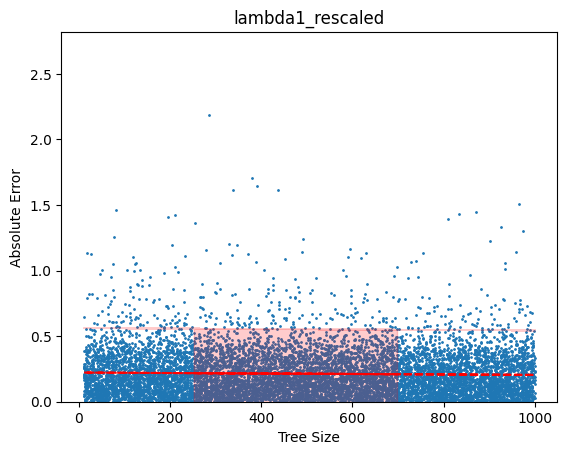

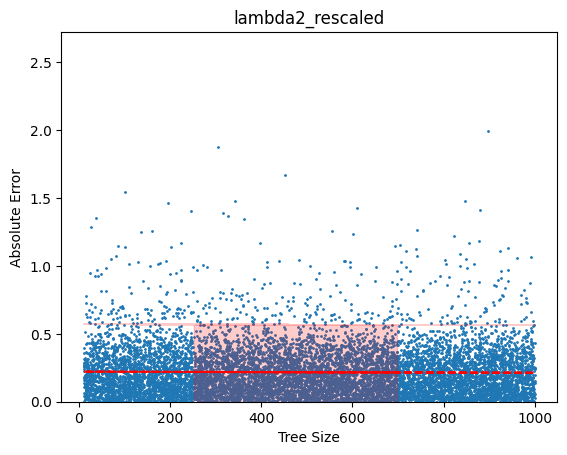

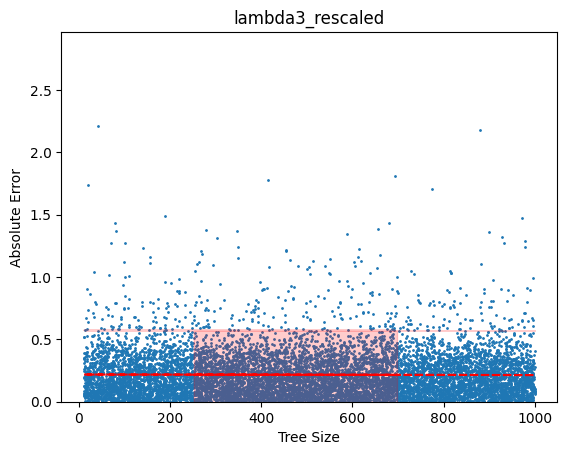

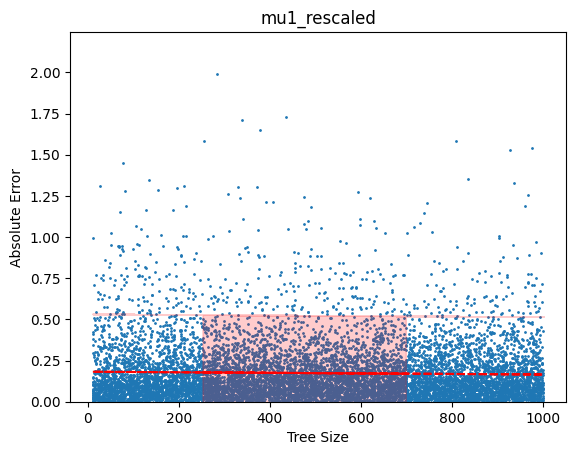

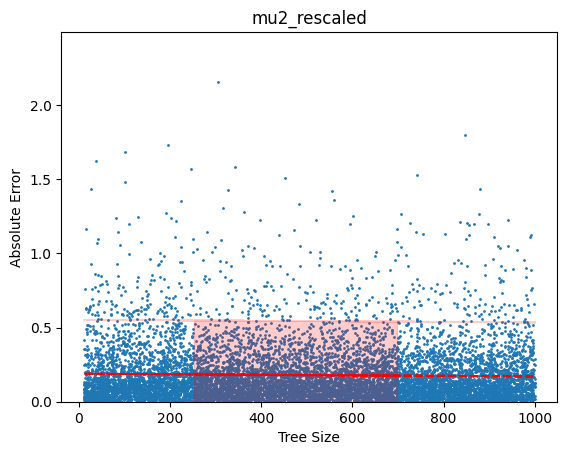

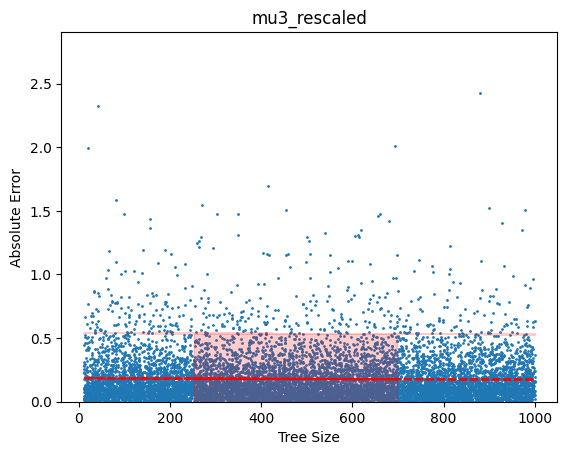

In [35]:
# plot absolute errors with respect to the tree size, the file is trees directory + model + ".sizes", text lines
sizes = []
with open(trees_directory + model_name + ".sizes", 'r') as f:
    sizes = f.readlines()
    sizes = [int(size) for size in sizes]
    

# take only the sizes that correspond to the test set
sizes = sizes[cutoff:]
errors = np.abs(Y_test - predictions)

# for each parameter, plot the absolute error vs. tree size
for i in range(targets.shape[1]):
    plt.scatter(sizes, errors.iloc[:, i], s=1)
    # add trend line
    z = np.polyfit(sizes, errors.iloc[:, i], 1)
    p = np.poly1d(z)
    plt.plot(sizes, p(sizes), "r--")
    # add 95% confidence interval
    plt.fill_between(sizes, p(sizes) - 1.96 * np.std(errors.iloc[:, i]), p(sizes) + 1.96 * np.std(errors.iloc[:, i]), color='r', alpha=0.2)
    plt.xlabel('Tree Size')
    plt.ylabel('Absolute Error')
    plt.title(targets.columns[i])
    # start from 0, set ylim to be the max value of the parameter
    maxval = Y_test.iloc[:, i].max()
    plt.ylim([0, maxval])
    plt.show()


In [230]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


320/320 [==============================] - 1s 3ms/step


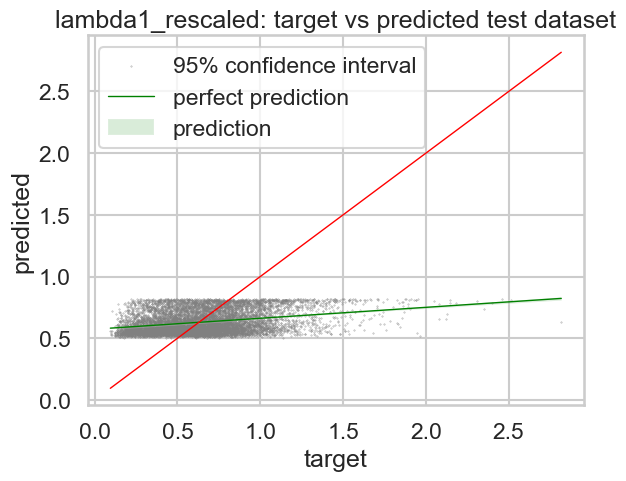

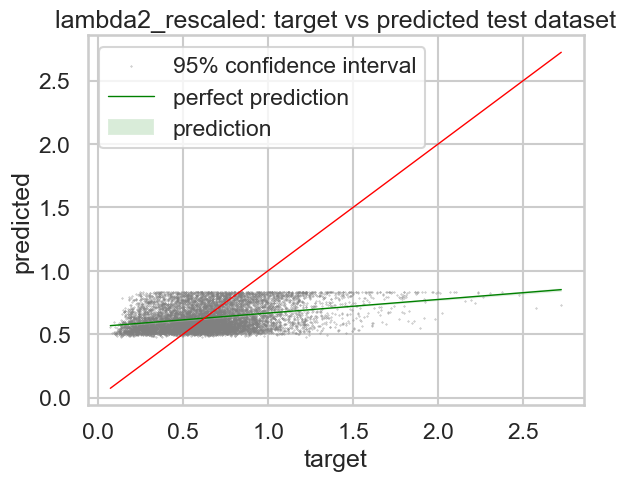

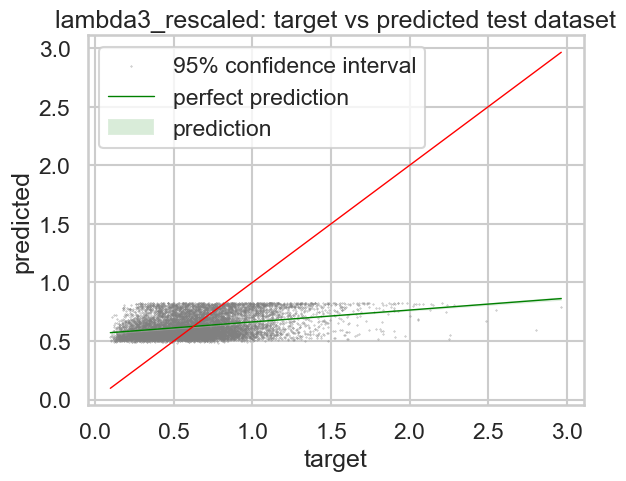

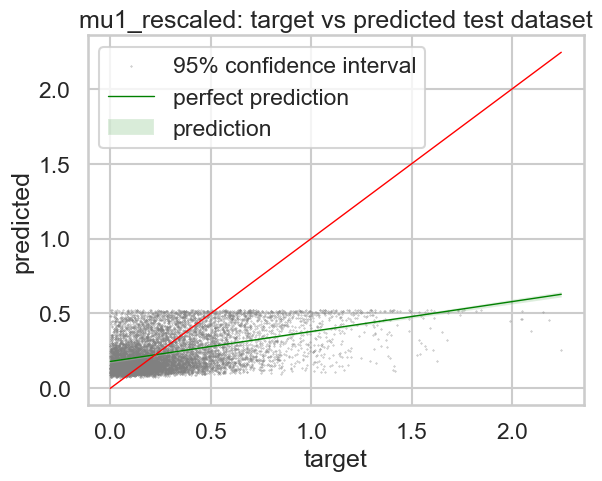

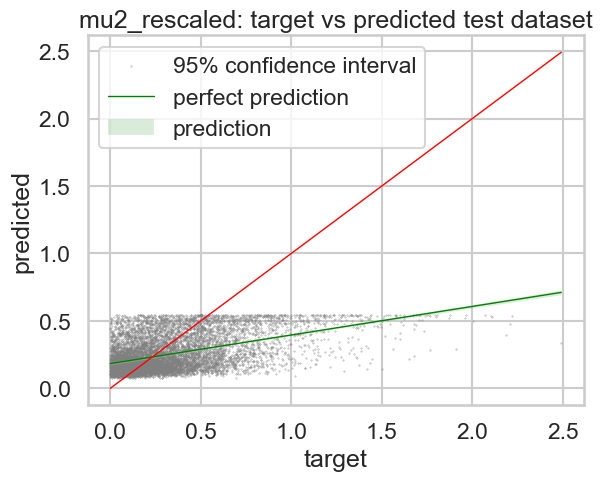

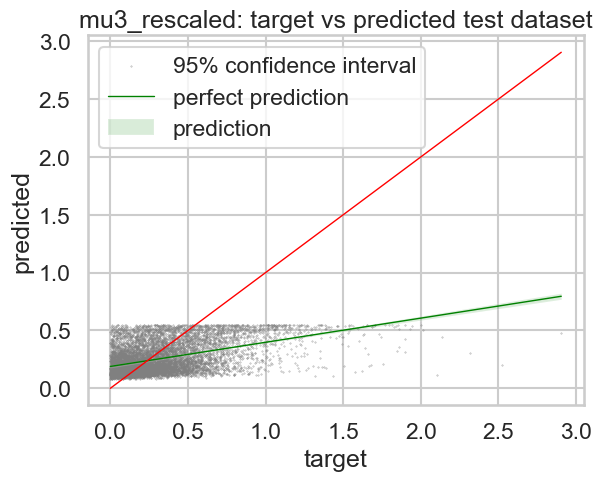

In [40]:
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(model.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)
    

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':1})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=1, color='red', label='perfect prediction')
    plt.legend(['95% confidence interval', 'perfect prediction', 'prediction'])
    
    plt.savefig(chemin + '/' + file_name_beg + '_target_vs_predicted.png')
    plt.show()
    return None

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    


for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)


    
    

In [39]:
###boxplots

from pylab import *

def sd_bins(name_target, name_predicted, nb_bins):
    b_indexes = np.digitize(df[name_predicted], bins=np.linspace(min(df[name_predicted]),max(df[name_predicted]),num=nb_bins))
    list_sd = []
    x_axis = []
    
    list_b = [[] for i in range(max(b_indexes)-1)]
    for i in range(1, nb_bins):
        list_b[i-1] = np.array(df[name_target][b_indexes == i])
        #print(df[name_target][b_indexes == i])
        #print(i)
        #print(len(df['predicted_minus_target_R_nought'][a_indexes == i]))
        if len(list_b[i-1]) > 1:
            list_sd.append(np.std(list_b[i-1]))
        else :
            list_sd.append([None])
    
    x_bins = np.linspace(min(df[name_predicted]), max(df[name_predicted]), num=nb_bins)
    
    for i in range(0,len(x_bins)-1):
        x_axis.append(float("{0:.1f}".format((x_bins[i]+x_bins[i+1])/2)))
        
    return list_b, list_sd, x_axis        

def plot_boxplot(name_target, name_predicted, nb_bin, maintitle, directory, file_name):
    min_val = min(df[name_target])
    
    max_val = max(df[name_target])
    
    arrays_target, array_sd, position_list = sd_bins(name_target, name_predicted, nb_bins=nb_bin)
    fig = plt.figure(figsize=(12,4))
    fig.suptitle(maintitle, fontsize=18, fontweight='bold')
    
    ax = fig.add_subplot(111)
    ax.boxplot(arrays_target, positions=position_list, notch=True)
    
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Target value')

    
    plt.plot(np.linspace(min_val, max_val, 5), np.linspace(min_val, max_val, 5), color='red')
    #plt.savefig('../Plots2/' + chemin + file_name + '.png')
    #plt.savefig('../Plots/' + directory + file_name + '.png')
    plt.show()
    return None
    
for elt in elts:
    plot_boxplot('target_'+elt, 'predicted_'+elt, 11, elt+': prediction precision', directory = chemin, file_name='boxplot_' + elt + '_pred_vs_target')

#plot_boxplot('target_sampling_proba','predicted_sampling_proba', 11 , 'Transmission rate: prediction precision', min_val=0, max_val=1, directory = chemin, file_name='boxplot_sampling_proba_pred_vs_target')


NameError: name 'elts' is not defined

In [190]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)



# do the same with scaled values

# multiply the errors by the mean of the scaling factor
errors_scaled = errors.copy()
errors_scaled['MAE'] = errors['MAE']*param_test['norm_factor'].mean()
errors_scaled['RMSE'] = errors['RMSE']*param_test['norm_factor'].mean()
errors_scaled['RME'] = errors['RME']

TypeError: can only concatenate str (not "int") to str

In [97]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


NameError: name 'elts' is not defined

In [176]:
#measure of correlation: predicted vs target
from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson_cors = []

for elt in elts:
    pearson_cors.append(pearsonr(Y_test[elt], predicted_test[elt])[0])

print("Global pearson correlation between predicted and effective parameter: ", Y_test.columns, pearson_cors)


Global pearson correlation between predicted and effective parameter:  Index(['lambda_rescaled', 'mu_rescaled'], dtype='object') [0.8369944960361664, 0.8590712664619697]


In [177]:
###save the model, weights (and scaler for sumstats only)

from tensorflow.keras.models import model_from_json

# save model
model_trial_1000 = model.to_json()
with open(chemin + '/model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
model.save_weights(chemin + '/model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


model saved!


"\nfrom sklearn.externals import joblib\n\nscale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'\njoblib.dump(scale, scale_filename)\n\nprint('scale saved!')\n#load scaler:\n#scale = joblib.load(scale_filename)\n"

In [178]:
####save the predicted and the target dataframes

Y_test.to_csv(chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv(chemin + expname + 'predicted_all.csv', header=True)

## Statistics and Visualization

In [50]:
import pandas as pd
chemin = './trained_models/musse/'
expname='90k'

# Read the data
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

In [51]:
table = pd.concat([Y_test.iloc[0], predicted_test.iloc[0]], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]
table['difference'] = table['difference'].apply(lambda x: f"{x:.2f}")
# set column names
table.columns = ['target', 'predicted', 'difference']
table


,target,predicted,difference
lambda1,0.382097,0.412127,-0.03
lambda2,0.235039,0.442063,-0.21
lambda3,0.475256,0.417001,0.06
mu1,0.274117,0.137396,0.14
mu2,0.143284,0.147131,-0.00
mu3,0.049107,0.147039,-0.10
q12,0.425354,0.488036,-0.06
q13,0.337658,0.495267,-0.16
q21,0.316298,0.500363,-0.18
q23,0.738986,0.486805,0.25


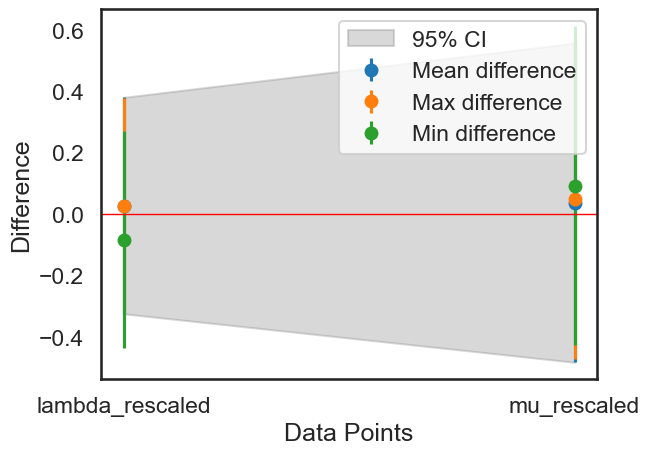

In [179]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Y_test and predicted_test are already defined

table = pd.concat([Y_test.mean(), predicted_test.mean()], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]

# Calculate upper and lower bounds for 95% confidence interval
ci = 1.96 * Y_test.std()  # 1.96 is the z-value for 95% confidence interval in a standard normal distribution
upper_ci = table['difference'] + ci
lower_ci = table['difference'] - ci

# plot also points at max values and min values
max_vals = pd.concat([Y_test.max(), predicted_test.max()], axis=1)
max_vals['difference'] = max_vals.iloc[:, 0] - max_vals.iloc[:, 1]
min_vals = pd.concat([Y_test.min(), predicted_test.min()], axis=1)
min_vals['difference'] = min_vals.iloc[:, 0] - min_vals.iloc[:, 1]
plt.errorbar(table.index, table['difference'], yerr=ci, fmt='o', label='Mean difference')
plt.errorbar(max_vals.index, max_vals['difference'], yerr=ci, fmt='o', label='Max difference')
plt.errorbar(min_vals.index, min_vals['difference'], yerr=ci, fmt='o', label='Min difference')
plt.fill_between(table.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='95% CI')

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Difference')
plt.legend()

# Show plot
plt.show()


In [134]:
# plot the absolute error with respect of the size of the tree
# compute the size of the tree
import numpy as np
import pandas as pd
import os
from ete3 import Tree

def get_tree_size(tree_file):
    with open(tree_file, 'r') as tree_file:
        forest = tree_file.read().replace("\n", "")
        trees = forest.split(";")
        sizes = []
        for i in range(0, len(trees)):
            print("\r" + "Processing tree " + str(i) + " of " + str(len(trees)))
            sys.stdout.flush()
            if len(trees[i]) > 0:
                tree = Tree(trees[i] + ";", format=1)
                size = len(tree.get_leaves())
                sizes.append(size)
        return sizes

# Load the tree files
trees_directory = "trees/"
tree_sizes = get_tree_size(trees_directory + model_name + ".nwk")

# Load the predicted and target values
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

# Calculate the absolute error
absolute_error = abs(Y_test - predicted_test)

# Plot the absolute error with respect to the size of the tree
plt.scatter(tree_sizes, absolute_error.mean(axis=1))
plt.xlabel('Tree Size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Tree Size')
plt.show()

    

Processing tree 0 of 90615
Processing tree 1 of 90615
Processing tree 2 of 90615
Processing tree 3 of 90615
Processing tree 4 of 90615
Processing tree 5 of 90615
Processing tree 6 of 90615
Processing tree 7 of 90615
Processing tree 8 of 90615
Processing tree 9 of 90615
Processing tree 10 of 90615
Processing tree 11 of 90615


ValueError: stat: path too long for Windows

## Tree plotting

In [5]:
import subprocess
import os
import matplotlib.pyplot as plt
from PIL import Image


# select from 

# Iterate over the first ten rows of Y_test and predicted_test
for i in range(1):
    # Define your Python lists
    y_test_list = Y_test.iloc[i].values.tolist()
    predicted_test_list = predicted_test.iloc[i].values.tolist()

    # Convert lists to strings
    y_test_str = ",".join(map(str, y_test_list))
    predicted_test_str = ",".join(map(str, predicted_test_list))
    
    max_taxa = str(30)

    try:
        # Start the R script using subprocess and pass the lists as arguments
        process = subprocess.Popen(["Rscript", "plot_trees.R", y_test_str, predicted_test_str, max_taxa],
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True)

        # Capture and print the standard output of the R process
        stdout, stderr = process.communicate()
        print("R script output:", stdout)

        # Check if there were any errors
        if process.returncode == 0:
            print("R script executed successfully.")
        else:
            print("R script execution failed with error code:", process.returncode)
            print("Error output:", stderr)
    except FileNotFoundError:
        print("Rscript command not found. Make sure R is installed and added to the system PATH.")
    except subprocess.CalledProcessError as e:
        print("R script execution failed:", e)
    except Exception as e:
        print("An error occurred:", e)
            


Rscript command not found. Make sure R is installed and added to the system PATH.


In [26]:
# quiet mode install of PyQt5
%pip install -q pyqt5

Note: you may need to restart the kernel to use updated packages.


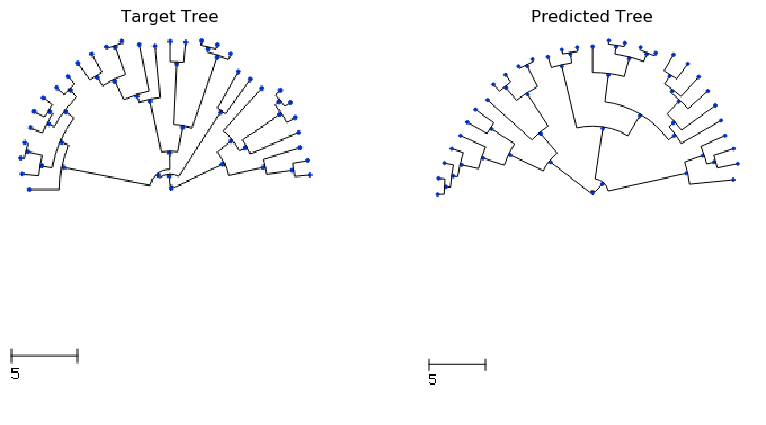

In [25]:
from ete3 import Tree, faces, TreeStyle

# read the tree from the file
target_tree = Tree("target.nwk", format=1)
predicted_tree = Tree("predicted.nwk", format=1)

# render the target tree
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.scale = 10
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()



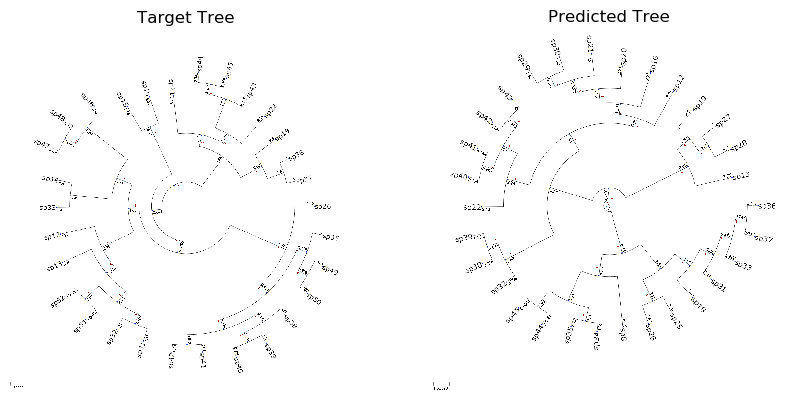

In [16]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight, color="RoyalBlue", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True

    return t, ts

t, ts = get_example_tree()

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()